In [1]:
import ROOT
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
import pandas as pd

Welcome to JupyROOT 6.26/04


In [2]:
#construct the model
class custom1(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.input = nn.Linear(in_dim, 100)
        self.layer0 = nn.Linear(100, 75)
        self.layer1 = nn.Linear(75,75)
        self.layer2 = nn.Linear(75,50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.ReLU()(self.input(x))
        x = nn.Tanh()(self.layer0(x))
        x = nn.ReLU()(self.layer1(x))
        x = nn.ReLU()(self.layer2(x))
        output = nn.Sigmoid()(self.output(x))
        return output


In [3]:
#creating dataset for training


transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip]
)

b_jet = (pd.read_csv("~/Week3_sample/b_jet.csv")).to_numpy()
c_jet = (pd.read_csv("~/Week3_sample/c_jet.csv")).to_numpy()
data_X = np.concatenate((b_jet, c_jet)) #data
#creating label for c_jet and b_jet: c -> 1, b -> 0
b_label = np.zeros((b_jet.shape[0]))
c_label = np.ones((c_jet.shape[0]))
data_y = np.concatenate((b_label, c_label)) #label for data
#split train and validation set:
X_train, X_vali, y_train, y_vali = train_test_split(data_X, data_y, test_size = 0.1, random_state=114514)
#dataset for pytorch
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))
#dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

In [17]:
print(c_jet.shape[0]/(b_jet.shape[0]+c_jet.shape[0]), b_jet.shape[0]/(b_jet.shape[0]+c_jet.shape[0]))


0.17692644343402728 0.8230735565659727
(434826,)


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 5
batch_size = 1000
learning_rate = 0.01

num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model = custom1(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.21, 1], device=device), reduction='none')
criterion = nn.BCELoss()
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle =True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle =True)

train_accu_lst, vali_accu_lst = [], []
train_loss_lst, vali_loss_lst = [], []
model.train()
for epoch in range(epochs):
    model.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizer.zero_grad()
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = model(X)
        #reconstruct criterion based on each data label
        weight = torch.clone(y)
        weight[weight[:, 0] == 0] = 0.21
        criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)
        

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    mean_loss = np.mean(train_losses)
    train_loss_lst.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    """
    #training accuracy
    with torch.no_grad():
        model.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            y = y.type(torch.FloatTensor)
            X, y = X.float().to(device), y.to(device)
            y = y.view(y.size(0), -1)
            prediction = model(X)

            _, prediction = torch.max(prediction.data, 1)
            accu = (prediction == y).sum().item()
            accu_list.append(accu/y.size(0))
        model.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            x, y = vali_data[0], vali_data[1]
            y = y.type(torch.LongTensor)
            x, y = x.float().to(device), y.to(device)
            y = y.view(y.size(0), -1)
            prediction = model(x)
            loss = criterion(prediction, y)

            _, prediction = torch.max(prediction.data, 1)
            accu = (prediction == y).sum().item()
            accu_list.append(accu/y.size(0))
            validation_losses.append(loss.item())
        model.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print("vali accu:", vali_accu)
        vali_accu_lst.append(vali_accu)
        """

device: cuda


  0%|          | 0/3914 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.18906077751904102


  0%|          | 0/3914 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.1385885190654605


  0%|          | 0/3914 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.13774657373944288


  0%|          | 0/3914 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.1372629263222705


  0%|          | 0/3914 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.1369175030147932


### Draw roc curve to see the performance

In [46]:
pred_lst = []
with torch.no_grad():
    model.eval()
    for vali_data in dataloader_vali:
        X, y = vali_data[0], vali_data[1]
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = model(X)
        prediction = prediction.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        result = np.hstack((prediction,y))
        pred_lst.append(result)
    model.train()

pred_label = np.concatenate(pred_lst)
print(pred_label.shape)
    
        

(434826, 2)


0.89613223 0.026078993 0.8965139 0.026143046


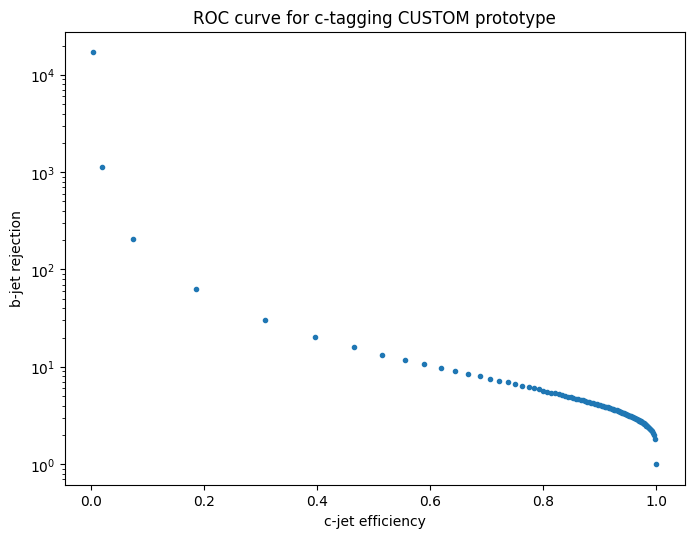

In [55]:
b_CUSTOM1 = pred_label[pred_label[:, 1] == 0]
c_CUSTOM1 = pred_label[pred_label[:, 1] == 1]
b_len, c_len = b_CUSTOM1.shape[0], c_CUSTOM1.shape[0]
print(np.max(b_CUSTOM1[:,0]), np.min(b_CUSTOM1[:,0]), np.max(c_CUSTOM1[:,0]), np.min(c_CUSTOM1[:,0]))

thresh_CUSTOM1 = np.linspace(0.026, 0.892, 100)
b_eff_CUSTOM1 = np.array([np.count_nonzero((b_CUSTOM1[:, 0] > thresh)) for thresh in thresh_CUSTOM1])/b_len
c_eff_CUSTOM1 = np.array([np.count_nonzero((c_CUSTOM1[:, 0] > thresh)) for thresh in thresh_CUSTOM1])/c_len
b_rej_CUSTOM1 = 1/b_eff_CUSTOM1


plt.figure(figsize=(8,6), dpi=100)
plt.plot(c_eff_CUSTOM1, b_rej_CUSTOM1, ".", label = "CUSTOM1")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM prototype")
plt.show()